In [50]:
import pandas as pd
from glob import glob
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [51]:
files = glob('內湖西段/直流功率/內湖西段-三期*.csv')
#print(files)

df3 = pd.concat(
    (pd.read_csv(file, usecols=['三期_17-18:17:805:mppt1_power:315'], dtype={'三期_17-18:17:805:mppt1_power:315':float}) for file in files), ignore_index=True)
df3=df3.dropna(axis=0)
print(df3.tail())

      三期_17-18:17:805:mppt1_power:315
2745                              0.0
2746                              0.0
2747                              0.0
2748                              0.0
2749                              0.0


In [52]:
# 產生 (X, Y) 資料集, Y 是下一期的發電量
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] #取dataset中所有一維的數據
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [53]:
# 正規化(normalize) 資料，使資料值介於[0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df3)

In [54]:
# 2/3 資料為訓練資料， 1/3 資料為測試資料
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [55]:
# 產生 (X, Y) 資料集, Y 是下一期的發電量(reshape into X=t and Y=t+1)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [56]:
# 建立及訓練 LSTM 模型
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1840/1840 - 3s - loss: 0.0255 - 3s/epoch - 2ms/step
Epoch 2/100
1840/1840 - 2s - loss: 0.0062 - 2s/epoch - 1ms/step
Epoch 3/100
1840/1840 - 2s - loss: 0.0062 - 2s/epoch - 1ms/step
Epoch 4/100
1840/1840 - 2s - loss: 0.0062 - 2s/epoch - 1ms/step
Epoch 5/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 6/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 7/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 8/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 9/100
1840/1840 - 2s - loss: 0.0062 - 2s/epoch - 1ms/step
Epoch 10/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 11/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 12/100
1840/1840 - 2s - loss: 0.0062 - 2s/epoch - 1ms/step
Epoch 13/100
1840/1840 - 2s - loss: 0.0062 - 2s/epoch - 1ms/step
Epoch 14/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 15/100
1840/1840 - 2s - loss: 0.0061 - 2s/epoch - 1ms/step
Epoch 16/100
1840/1840 - 2s - loss

In [57]:
# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

29/29 [==============================] - 0s 1ms/step


In [58]:
# 回復預測資料值為原始數據的規模
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [59]:
# calculate 均方根誤差(root mean squared error)
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


In [64]:
from sklearn.metrics import r2_score
r2=r2_score(testY[0],testPredict[:,0])
print("r2=",r2)

r2= 0.9378770753491108


In [61]:
# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [62]:
# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

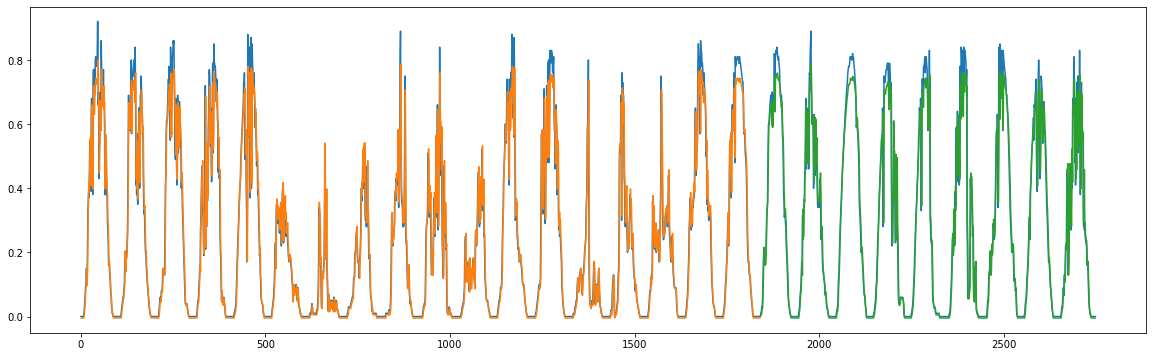

In [63]:
# 畫原始資料趨勢圖
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()